In [2]:
import pandas as pd

# read driving_log.csv
# Columns:
# Center, Left, Right, Steering Angle, Throttle, Break, Speed

df = pd.read_csv('data/driving_log.csv', header=None)

In [3]:
# number of data
len(df)

349

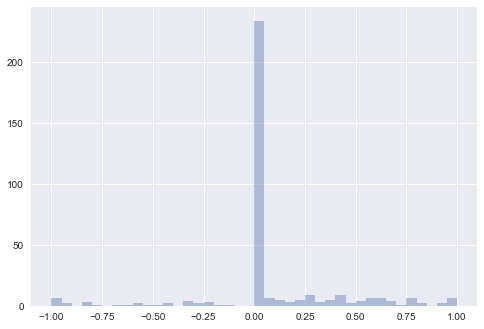

In [4]:
# print steering angle distribution
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)
sns.distplot(df[[3]], kde=False, bins=40)

The provided data is very unbalanced most steering angles are around 0.00 which means that car was mostly driving straight ahead.

In [9]:
import os
import math
import cv2
import numpy as np

def read_image(fname):
    """
    Reads file and returns image
    """
    if not os.path.isfile(fname):
        raise FileNotFoundError

    return plt.imread(fname)

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def create_roi_vertices(image):
    """
    Creates the vertices of a trapezoid that is used as the region of interest.
    """
    xsize =  image.shape[1]
    ysize =  image.shape[0]
    
    # defines the trapezoid
    trap_left_bottom = (0,ysize)
    trap_left_top = (50, 0)
    trap_right_top = (250, 0)
    trap_right_bottom = (xsize,ysize)
    
    vertices = np.array([[trap_left_bottom, trap_left_top, trap_right_top, trap_right_bottom]], dtype=np.int32)
    
    return vertices

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def calc_slope_and_intercept(x1, y1, x2, y2):
    """
    Calculates the slope and intercept values for two points.    
    """
    deltaX = x2 - x1
    
    # Division by 0 is not allowed. Therefore check deltaX
    if math.fabs(deltaX) < 0.00001:
        return float('NaN'), float('NaN')
    
    slope = (y2-y1) / (x2-x1)
    
    # y = mx * b => b = -mx + y
    intercept = (-1) * slope * x1 + y1
    
    return slope, intercept

def get_line(slope, intercept, y1, y2):
    """
    Calculates the start and end point based on given slope and intercept values
    and the y start and end values of two points.
    """
   
    # we do not take invalid slopes as well as slope values which are below 0.5
    # into account.
    #if math.fabs(slope) < 0.5 or np.isnan(slope) or np.isnan(intercept):
    if np.isnan(slope) or np.isnan(intercept) or math.fabs(slope) < 0.45:
        return []
    
    calc_x = lambda y,m,b : int(round((y - b) / m))
    
    x1 = calc_x(y1,slope,intercept)
    x2 = calc_x(y2,slope,intercept)
    
    return [(x1,y1), (x2,y2)]

def separate_lines(img, lines, draw_lines = True):
    """
    separates left from right lane lines and returns them 
    """
    color = [0, 255, 0] 
    thickness = 2    
    left = []
    right = []
    
    for line in lines:
        for x1,y1,x2,y2 in line:
            # lines with an invalid slope will not be taken into account
            slope,intercept = calc_slope_and_intercept(x1, y1, x2, y2)                                
                                  
            if np.isnan(slope):
                continue
                               
            # This line belongs to the left lines if the x value of the second point x2
            # is smaller then imagewidth/2.
            if x2 < img.shape[1]/2:
                left.append((x1, y1, x2, y2,slope,intercept))    
            else:
                right.append((x1, y1, x2, y2,slope,intercept))
               
            # Draw lines
            if draw_lines:
                cv2.line(img, (x1,y1), (x2,y2), color, thickness)
    
    # remove outliers
    left_median = np.median(np.array([slope for _, _, _, _, slope, _ in left]))
    right_median = np.median(np.array([slope for _, _, _, _, slope, _ in right]))
    
    # keep only those points whose slopes are not greater or less than 20% of the median
    deltaLeft = math.fabs(left_median) * 0.1
    deltaRight =  math.fabs(right_median) * 0.1
    
    left_new = [[x1, y1, x2, y2] for (x1, y1, x2, y2, slope, intercept) in left 
               if left_median - deltaLeft <= slope and slope <= left_median + deltaLeft]
    
    right_new = [[x1, y1, x2, y2] for (x1, y1, x2, y2, slope, intercept) in right 
               if right_median - deltaRight <= slope and slope <= right_median + deltaRight]
        
    return left_new, right_new
 
def extrapolate(lines, from_, to_):
    from scipy import stats
    
    pointsX = []
    pointsY = []
    
    for x1,y1,x2,y2 in lines:
        pointsX.append(x1)
        pointsX.append(x2)
        pointsY.append(y1)
        pointsY.append(y2)

    slope, intercept, r_value, p_value, std_err = stats.linregress(pointsX, pointsY)      
    
    print("slope {}, intercept {}".format(slope, intercept))
    
    return get_line(slope, intercept, from_, to_)
        
def draw_lines(img, left, right,from_, to_, color=[255, 0, 0], thickness=2):
    """
    Draws a single line over the left and right lane. It does a linear regression
    and calculates the top and bottom point for the calculated line.
    """        
    if len(left) > 0:
        print("LEFT")
        leftPoints = extrapolate(left, from_, to_)

        if (len(leftPoints) > 0):        
            cv2.line(img, leftPoints[0], leftPoints[1], color, thickness)

    if len(right) > 0:
        print("RIGHT")
        rightPoints = extrapolate(right, from_, to_)

        if (len(rightPoints) > 0):
            cv2.line(img, rightPoints[0], rightPoints[1], color, thickness)
    
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    
    return (line_img, lines)

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)


steering angle: 0.0


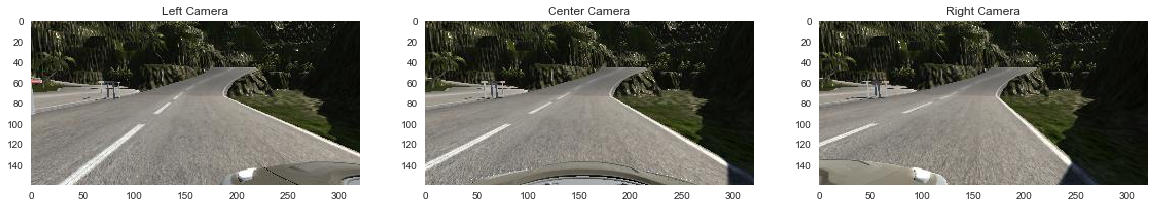

In [19]:
from PIL import Image

# Lets have a look at center, left and right image
center_img = Image.open(df.iat[100,0])
left_img = Image.open(df.iat[100,1])
right_img = Image.open(df.iat[100,2])

# show steering value 
print("steering angle: {}".format(df.iat[100,3]))

plt.rcParams['figure.figsize'] = (20, 10)
fig = plt.figure()

ax = fig.add_subplot(1, 3, 1)
ax.grid(False)
ax.imshow(left_img)
ax.set_title("Left Camera")

ax = fig.add_subplot(1, 3, 2)
ax.grid(False)
ax.imshow(center_img)
ax.set_title("Center Camera")

ax = fig.add_subplot(1, 3, 3)
ax.grid(False)
ax.imshow(right_img)
ax.set_title("Right Camera")

(160, 320, 3)
LEFT
slope -0.5055681583831718, intercept 60.84522581975665
RIGHT
slope 0.5805927389132888, intercept -111.61939885542974
(160, 320, 3)
LEFT
slope -0.7270117786796001, intercept 99.53642482430962
RIGHT
slope 0.4512703162588746, intercept -91.91873496450155


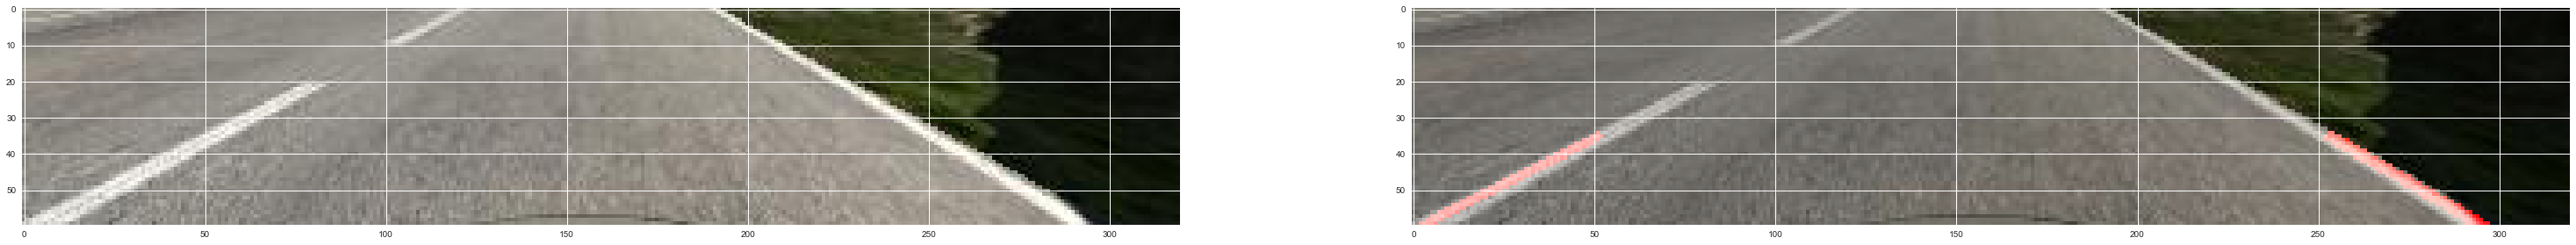

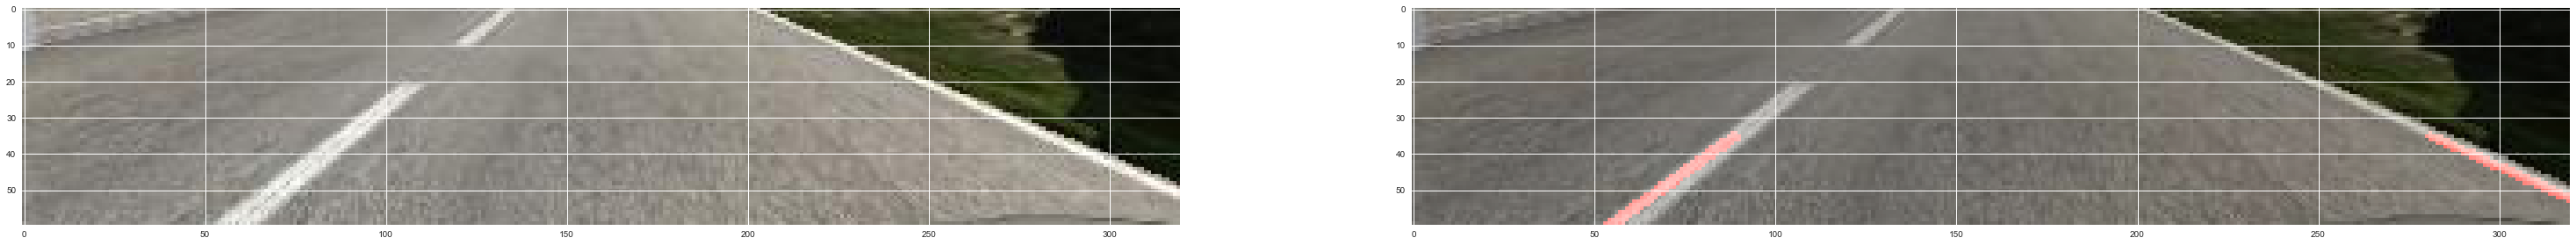

In [28]:
test_images = [df.iat[100,0], df.iat[100,1]]

for image_name in test_images:
    fig = plt.figure()
    fig.set_figheight(10)
    fig.set_figwidth(52)
      
    image = read_image(image_name)
    
    print (image.shape)
    
    image = image[80:140, 0:320]
    ax = fig.add_subplot(121)
    ax.imshow(image)
    
    # convert it to grayscale
    gray = grayscale(image)
    
    #ax = fig.add_subplot(242)
    #ax.imshow(gray, cmap="gray")
    
    # apply gaussian blur to smooth the images
    blur_gray = gaussian_blur(gray,kernel_size = 5)
    
    # use canny for edge detection
    edges = canny(blur_gray, low_threshold = 90, high_threshold = 180)
      
    # restrict the area where we want to search for lane lines
    vertices = create_roi_vertices(edges)
    roi_image = region_of_interest(edges, vertices)
    
    # apply hough transform to detect lines within the region of interest
    base_img, lines = hough_lines(np.copy(roi_image), rho=2, theta=np.pi/180, threshold=15, min_line_len=20, max_line_gap=40)
    
    # Show all lines that were found
    all_lines = base_img.copy()
    left, right = separate_lines(all_lines, lines)
    
    # Apply linear regression on left and right lines and display
    # the detected lines
    interpolated_lines = base_img.copy()     
    # interpolated lines
    yRatio = 0.59  
    from_ = image.shape[0]
    to_ = int(round(yRatio * image.shape[0]))
    draw_lines(interpolated_lines, left, right, from_, to_)
    
    # Overlay original image with interpolated lines
    final_image = weighted_img(interpolated_lines, image)
    
    ax = fig.add_subplot(122)
    ax.imshow(final_image)

Now lets find the intercept points for the left and right lanes of the center as well as for the left image. Therefore, we take the slopes and intercepts and solve the linear systems as shown below. Now we're able to calculate the distance (in pixel) from the center camera to left or right camera.  

In [40]:
# Linear equation
# x2 = kx1 + d
# -d = kx1 - x2
# Solve linear systems for center image
a_center = np.array([[-0.506, -1.0],[0.581, -1.0]])
b_center = np.array([-60.845, 111.619])
x_center = np.linalg.solve(a_center, b_center)

# Solve linear systems for left image
a_left = np.array([[-0.727, -1.0],[0.451, -1.0]])
b_left = np.array([-99.536, 91.919])
x_left = np.linalg.solve(a_left, b_left)

b = 60 + abs(x_center[1] + x_left[1]) / 2.0
a = x_left[0] - x_center[0]

slope = b / a
angle = np.arctan(slope)
delta = angle / 25.0

print("Center : {}, Left : {}".format(x_center, x_left))
print( "slope : {}, angle : {}, delta : {}".format(slope, angle, delta))

steering_left = delta
steering_right = -delta

Center : [ 158.66053358  -19.43722999], Left : [ 162.52546689  -18.62001443]
slope : 20.447603045811523, angle : 1.521929773048198, delta : 0.06087719092192792


### Data Augmentation
In the next cells we will augment our data. The following methods will be applied to the available images.
- Image flipping
- Adding an artifical shadow

In [42]:
def flip_image(image, steering_angle):
    image_flipped = np.fliplr(image)
    steering_angle_flipped = -steering_angle
    
    return image_flipped, steering_angle_flipped

def add_shadow(image):
    return image

### Data Generator

Generates batches of sample on the fly.

In [75]:
# Split samples into training and validation samples.
from sklearn.model_selection import train_test_split
train_samples, validation_samples = train_test_split(df, test_size=0.2)

import cv2
import numpy as np
import sklearn

# Taken from Stackoverflow:
# http://stackoverflow.com/questions/25699439/how-to-iterate-over-consecutive-chunks-of-pandas-dataframe-efficiently
def chunker(seq, size):
    return (seq[pos:pos + size] for pos in range(0, len(seq), size))

def generator(samples, batch_size=32):
    num_samples = len(samples)
        
    while 1: # Loop forever so the generator never terminates
        samples = sklearn.utils.shuffle(samples)
        for batch_samples in chunker(samples,batch_size):
           
            images = []
            angles = []
            for batch_sample in chunker(batch_samples, 1):
                # Center image
                path = batch_sample.iat[0,0]
                center_image = cv2.imread(path)
                center_angle = float(batch_sample[3])
                images.append(center_image)
                angles.append(center_angle)
                
                # Left image
                path_left = batch_sample.iat[0,1]
                left_image = cv2.imread(path_left)
                left_angle = float(batch_sample[3]) + steering_left
                images.append(left_image)
                angles.append(left_angle)
                
                # Right image
                path_right = batch_sample.iat[0,1]
                right_image = cv2.imread(path_right)
                right_angle = float(batch_sample[3]) + steering_right
                images.append(right_image)
                angles.append(right_angle)
                
                
            # trim image to only see section with road
            X_train = np.array(images)
            y_train = np.array(angles)
            
            yield sklearn.utils.shuffle(X_train, y_train)

# compile and train the model using the generator function
train_generator = generator(train_samples, batch_size=128)
validation_generator = generator(validation_samples, batch_size=128)

### Nvidia Model

In the following cell the model is created. The model is based on nvidia's model which was used in their paper.

In [78]:
from keras.layers.core import K
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, Activation
from keras.layers import Conv2D, MaxPooling2D, Input
from keras.layers.pooling import AveragePooling2D
from keras.layers import Cropping2D
from keras.layers.core import Dropout
from keras.layers.normalization import BatchNormalization

def nvidia_net():
    keep_prob = 0.5
    keep_prob_fc = 0.5

    model = Sequential()

    # pre-processing
    model.add(Cropping2D(cropping=((40,25), (0,0)), input_shape=(160,320,3)))
    model.add(Lambda(lambda x: K.tf.image.resize_images(x, (66,200)))) # resize image
    model.add(Lambda(lambda x: (x - 128.0) / 128.0)) # normalization
        
    # Convnet
    
    model.add(Conv2D(24, 5, strides=(2,2), padding='valid', activation='relu'))
    model.add(Dropout(keep_prob))

    model.add(Conv2D(36, 5, strides=(2,2), padding='valid', activation='relu'))
    model.add(Dropout(keep_prob))

    model.add(Conv2D(48, 5, strides=(2,2), padding='valid', activation='relu'))
    model.add(Dropout(keep_prob))

    model.add(Conv2D(64, 3, activation='relu'))
    model.add(Dropout(keep_prob))

    model.add(Convolution2D(64, 3, activation='relu'))
    model.add(Dropout(keep_prob))

    # FC
    model.add(Flatten())
    model.add(Dense(100))
    model.add(Dropout(keep_prob_fc))
    model.add(Dense(50))
    model.add(Dropout(keep_prob_fc))
    model.add(Dense(10))
    model.add(Dropout(keep_prob_fc))
    model.add(Dense(1))

    return model

In [79]:
# Print model summary
model_n = nvidia_net()
model_n.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cropping2d_16 (Cropping2D)   (None, 95, 320, 3)        0         
_________________________________________________________________
lambda_31 (Lambda)           (None, 66, 200, 3)        0         
_________________________________________________________________
lambda_32 (Lambda)           (None, 66, 200, 3)        0         
_________________________________________________________________
conv2d_76 (Conv2D)           (None, 31, 98, 24)        1824      
_________________________________________________________________
dropout_121 (Dropout)        (None, 31, 98, 24)        0         
_________________________________________________________________
conv2d_77 (Conv2D)           (None, 14, 47, 36)        21636     
_________________________________________________________________
dropout_122 (Dropout)        (None, 14, 47, 36)        0         
__________

In [80]:
# Mean square error function is used as loss function because this 
# is a regression problem.
model_n.compile(loss='mse', optimizer='adam', metrics=['accuracy'])

# fit_generator(self, generator, steps_per_epoch, epochs=1, verbose=1, callbacks=None, 
#     validation_data=None, validation_steps=None, class_weight=None, 
#     max_q_size=10, workers=1, pickle_safe=False, initial_epoch=0)

model_n.fit_generator(train_generator, 
                      steps_per_epoch = len(train_samples),
                      epochs = 1,
                      validation_data=validation_generator,
                      validation_steps=len(validation_samples))

Epoch 1/1
279/279 [==============================] - 408s - loss: 0.1136 - acc: 0.6652 - val_loss: 0.1154 - val_acc: 0.6429

In [83]:
# save model
model_n.save('./model.h5')


In [84]:
from keras.models import load_model
import h5py
# load model
model = load_model('./model.h5')

0.06568245589733124
